## Convergence Benchmark

In [ ]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from qiskit.quantum_info import random_unitary
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *
#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [54]:
def generate_spam_benchmark(n=3, c1=1, c2=1):
    d = 2**n
    spam_target = SPAM(d=d)

    init_target = c1*init_ideal(d) + (1-c1)*spam_target.init
    povm_target = c2*povm_ideal(d) + (1-c2)*spam_target.povm

    spam_target = SPAM(d=d,
                       init = init_target,
                       povm = povm_target)
    
    return spam_target


def generate_spam_data(spam_target, N_spam=None, noise=0):
    n = spam_target.n
    inputs_spam, _ = generate_pauliInput_circuits(n, N_spam)
    N_spam = inputs_spam.shape[0]

    state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
    state = apply_unitary(state, inputs_spam)
    targets_spam = measurement(state, povm = spam_target.povm)

    #add noise
    targets_spam = add_noise_to_probs(targets_spam, noise=noise)
    return inputs_spam, targets_spam


def generate_map_data(channel_target, spam_target, N_map=None, noise=0):
    n = int(np.log2(channel_target.d))
    inputs_map, _ = generate_pauli_circuits(n = n, 
                                            circuit_target=None,  
                                            trace=False,
                                            N=N_map)
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis, spam_target.povm)
    
    return inputs_map, targets_map


def povm_fidelity(spam_a, spam_b):
    d = spam_a.d
    povm_a, povm_b = spam_a.povm, spam_b.povm
    ab = tf.matmul(povm_a, povm_b)
    ab_sqrt = tf.linalg.sqrtm(ab)
    fidelity = tf.math.reduce_sum(tf.linalg.trace(ab_sqrt))/d
    return fidelity


def model_pipeline(channel_target, noise, N_map=2000, rank = None):
    # Make Benchmark
    #################################################################################
    d = channel_target.d
    if rank is None:
        rank = d**2
    
    spam_target = generate_spam_benchmark(n=n, c1=0.8, c2=0.8)
    inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

    inputs_map, targets_map = generate_map_data(channel_target, spam_target, N_map=N_map, noise=noise)
    #################################################################################

    # Fit Models
    #################################################################################
    spam_model = SPAM(d=d,
                      use_corr_mat=True,
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))

    spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                        num_iter = 300,
                        verbose = False,
                        )

    spam_model.train(inputs = inputs_spam,
                     targets = targets_spam,
                     num_iter = 2000,
                     verbose = False,
                    )

    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                               rank = rank,
                                               spam = spam_model,
                                              ),
                            loss_function = ProbabilityMSE(),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            logger = Logger(loss_function = channel_fidelity_loss),
                           )

    model.train(inputs = inputs_map,
                targets = targets_map,
                inputs_val = None,
                targets_val = [channel_target],
                num_iter = 4000,
                N = 500,
                )
    #################################################################################

    return model

## Retrieve SPAM and Map

In [68]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 1
d = 2**n

channel_target = DilutedKrausMap( 
                               U=generate_unitary(d=d), 
                               c=0.5, 
                               d=d, 
                               rank=d-1,
                              )
model_list1 = []
for i in tqdm(range(10)):
    
    model = model_pipeline(channel_target, noise = 1/np.sqrt(1000), N_map=None)
    model_list1.append(model)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0005139951535039114


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.5193956138541608
None -0.8634358047036302
None -0.9313798626698676
None -0.948363146717546
None -0.9555418138339442
None -0.9592574861373034
None -0.9614230951036297
None -0.962789981505742
None -0.9637046230281023
None -0.9643451882088475
None -0.964810627835349
None -0.9651591589043457
None -0.965426515368078
None -0.9656355303941498
None -0.9658013762210109
None -0.9659344422463557
None -0.9660421665658703
None -0.9661299876815865
None -0.9662019872798442
None -0.9662613111549242
None -0.9663103729245381
None -0.9663510999122882
None -0.9663849521661732
None -0.966413118698981
None -0.9664365487489663
None -0.9664559970446654
None -0.966472092003682
None -0.9664853338056698
None -0.9664961576170029
None -0.9665049563554541
None -0.9665120260194716
None -0.966517651369995
None -0.9665220976034615
None -0.9665255393685107
None -0.9665281732807884
None -0.9665301726250369
None -0.9665316515555149
None -0.9665327303137539
None -0.9665335175042248
None -0.966534050302502
None -0.

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00036824465333251964


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.38743462709834836
None -0.8505002911884227
None -0.9566692965072165
None -0.9700156314698933
None -0.9741141119960584
None -0.9757984917900826
None -0.9765890542068758
None -0.9769800885296345
None -0.9771758050646407
None -0.9772726396661361
None -0.9773192738409684
None -0.9773408051087507
None -0.9773502177207241
None -0.9773540612922661
None -0.9773555118061794
None -0.977356011813261
None -0.9773561565261937
None -0.9773561936736538
None -0.9773562065858132
None -0.9773562065541156
None -0.9773562047016537
None -0.977356212459364
None -0.9773562108985772
None -0.9773562109247466
None -0.9773562037638271
None -0.9773561963431338
None -0.9773562037321836
None -0.9773562001451226
None -0.9773562090357946
None -0.9773562065420073
None -0.9773562034256897
None -0.9773562012699823
None -0.977356214323701
None -0.9773562091565923
None -0.9773562060889165
None -0.9773562022830883
None -0.9773562091954724
None -0.9773562149987313
None -0.977356205354058
None -0.9773562065050345
Non

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0007693378009359602


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.6174891975996512
None -0.8823699917947042
None -0.9446854141621532
None -0.9635740133612873
None -0.9714587086849807
None -0.975455517248462
None -0.9777413777800681
None -0.9791530502533221
None -0.980071797575653
None -0.9806929228295481
None -0.98112518325094
None -0.9814329803813281
None -0.981656111776805
None -0.9818200589347557
None -0.9819416004412777
None -0.9820321356539425
None -0.9820995953908314
None -0.9821497532288895
None -0.9821868431164447
None -0.9822140866367669
None -0.9822339360930126
None -0.982248291479853
None -0.9822585776003815
None -0.9822658868760007
None -0.9822710610684025
None -0.9822747019395347
None -0.9822772529338032
None -0.9822790419784649
None -0.9822802872526032
None -0.9822811520839593
None -0.9822817686810921
None -0.9822821792394172
None -0.9822824657866049
None -0.9822826691129818
None -0.982282803073655
None -0.9822828827877668
None -0.9822829431650808
None -0.9822829712051356
None -0.9822830021523947
None -0.982283002822153
None -0.

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0004958215876330925


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.3634836030581072
None -0.8661215303505551
None -0.9395358040033301
None -0.960634975134774
None -0.9688919780600375
None -0.9727818978017435
None -0.9747964979067941
None -0.9758768845877822
None -0.9764534298578402
None -0.9767509618816589
None -0.9768961150803366
None -0.9769617144299413
None -0.976988488143053
None -0.9769978588415132
None -0.9770002955762357
None -0.9770003627111925
None -0.9769998868401267
None -0.9769994356903725
None -0.9769991223925848
None -0.9769989504890665
None -0.976998855717972
None -0.9769988201025073
None -0.9769987828038962
None -0.976998772800658
None -0.9769987794780559
None -0.9769987690837073
None -0.9769987768148825
None -0.976998778392898
None -0.976998779974031
None -0.9769987870607845
None -0.9769987822079435
None -0.9769987804968566
None -0.9769987836878847
None -0.9769987777416068
None -0.9769987756045341
None -0.976998778907639
None -0.9769987809456641
None -0.9769987790980574
None -0.976998771626097
None -0.976998778509048
None -0.9

  0%|          | 0/2000 [00:00<?, ?it/s]

8.443354002961536e-05


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.5382056879191272
None -0.9267575300086376
None -0.9600506185984404
None -0.9712082140229907
None -0.97589698977354
None -0.978244887708872
None -0.9795848941906489
None -0.9804212428323985
None -0.9809760733608486
None -0.9813597114807789
None -0.9816324021410926
None -0.9818296073363102
None -0.9819735664647369
None -0.9820789922522063
None -0.9821560632125802
None -0.9822120511993616
None -0.9822523073989855
None -0.9822808844102894
None -0.9823008200678616
None -0.9823144657140791
None -0.982323580784166
None -0.9823295119318513
None -0.9823332888340758
None -0.982335585055424
None -0.982336960448557
None -0.9823377364179859
None -0.9823381602311119
None -0.9823383778239873
None -0.9823384801957014
None -0.9823385261289523
None -0.9823385348554563
None -0.9823385391291053
None -0.9823385420438119
None -0.9823385439923101
None -0.9823385471082821
None -0.9823385410584496
None -0.9823385372039248
None -0.9823385396089167
None -0.9823385416844046
None -0.9823385373100014
None -

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00031128779548878486


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.5523803238626184
None -0.9238667294295058
None -0.9575970318765057
None -0.9649633029343104
None -0.9675246259080508
None -0.9685615010845469
None -0.9690024632562283
None -0.969190255442973
None -0.9692680480104137
None -0.9692991176121338
None -0.969311217850838
None -0.9693159453269314
None -0.9693178524129941
None -0.969318635852816
None -0.969318975518893
None -0.9693191107977196
None -0.9693191655418406
None -0.9693191896737308
None -0.9693191870738975
None -0.969319201742147
None -0.9693192035257816
None -0.9693191934154504
None -0.9693191901358588
None -0.9693191968751876
None -0.9693191896008236
None -0.9693192015526748
None -0.9693191931800808
None -0.9693192040076989
None -0.9693192068174145
None -0.9693192020027337
None -0.9693191947633933
None -0.9693191946736854
None -0.9693191937006959
None -0.9693192003816308
None -0.9693191972711663
None -0.9693192001793469
None -0.9693191955515449
None -0.9693191945131513
None -0.9693191999354022
None -0.969319200857167
None -

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0002605591301137088


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.227871391564786
None -0.8291537615132921
None -0.9674638253809057
None -0.9836506298471335
None -0.9874383705530433
None -0.9886852990980616
None -0.9891241280599612
None -0.9892744694293016
None -0.9893230510016067
None -0.9893378851608781
None -0.9893422666265288
None -0.9893435322105515
None -0.9893439022751997
None -0.9893440192332753
None -0.9893440507290989
None -0.9893440566894032
None -0.9893440595886837
None -0.9893440644553975
None -0.9893440519152529
None -0.989344059563203
None -0.9893440570846138
None -0.9893440542640145
None -0.989344058143655
None -0.9893440594361685
None -0.9893440552037877
None -0.9893440617544488
None -0.9893440530704047
None -0.9893440512498134
None -0.9893440607277345
None -0.9893440565990232
None -0.9893440577973625
None -0.98934406386052
None -0.9893440554240335
None -0.9893440675333657
None -0.9893440640561214
None -0.9893440539223815
None -0.9893440556686708
None -0.9893440610353205
None -0.989344059105025
None -0.9893440630766823
None -

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00013239678793478655


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.3292733142906304
None -0.8976636302303795
None -0.956206905198728
None -0.9694975793803943
None -0.9740639820066439
None -0.9757809412390118
None -0.976429813211178
None -0.9766766802793738
None -0.9767728955824185
None -0.9768105916792225
None -0.9768248205084283
None -0.9768297949083456
None -0.9768313889797592
None -0.9768318592071862
None -0.976831967209337
None -0.9768319939673201
None -0.9768319892886883
None -0.9768319898748162
None -0.9768319902654218
None -0.9768319933101027
None -0.976831999787443
None -0.9768319963341322
None -0.9768320012831883
None -0.9768319983154852
None -0.9768320015828454
None -0.9768320038295714
None -0.9768320010885861
None -0.9768319917627198
None -0.9768319920293446
None -0.9768319923333539
None -0.9768319934598436
None -0.976831992134365
None -0.9768319974802682
None -0.9768319979591092
None -0.976831997757629
None -0.976832000509027
None -0.9768319972353607
None -0.9768319903022763
None -0.9768319959228586
None -0.9768319940612121
None -0

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00015724816170415996


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.5702067732687154
None -0.9378278204261297
None -0.9806978103048394
None -0.9889729914591846
None -0.9914332828789172
None -0.9923582284808805
None -0.9927820822528738
None -0.9929891353244804
None -0.9930883266134336
None -0.9931333410982518
None -0.9931523454192689
None -0.9931597149328913
None -0.993162317494622
None -0.9931631448696946
None -0.993163391816695
None -0.9931634526038792
None -0.9931634819159578
None -0.9931634684663294
None -0.9931634709143283
None -0.9931634675320821
None -0.9931634784112208
None -0.9931634763163374
None -0.9931634730268406
None -0.9931634816760697
None -0.9931634771083936
None -0.9931634832572137
None -0.9931634690254922
None -0.9931634686798241
None -0.9931634708142268
None -0.9931634730918885
None -0.9931634681175272
None -0.9931634701221921
None -0.9931634740144337
None -0.9931634752073718
None -0.9931634763927374
None -0.9931634684671578
None -0.9931634795119327
None -0.99316347908994
None -0.9931634738384594
None -0.9931634758964948
None

  0%|          | 0/2000 [00:00<?, ?it/s]

1.909634479221858e-05


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.4790463690761069
None -0.8760466423412082
None -0.9493270974257745
None -0.9641254444637859
None -0.9688380264796081
None -0.970616524268852
None -0.971302940985152
None -0.9715598920102954
None -0.9716541189058919
None -0.9716890081152361
None -0.9717021467379018
None -0.9717070519676905
None -0.9717087964055386
None -0.9717093777934064
None -0.9717095484770677
None -0.9717095973811137
None -0.9717096063651738
None -0.971709613816492
None -0.9717096078705472
None -0.9717096210486716
None -0.971709615357192
None -0.9717096177958592
None -0.9717096134248222
None -0.9717096174958999
None -0.9717096242242724
None -0.9717096089292961
None -0.9717096241975514
None -0.9717096116512587
None -0.9717096147727692
None -0.9717096200461729
None -0.9717096126036573
None -0.9717096090145443
None -0.9717096147619537
None -0.9717096109089336
None -0.9717096251236554
None -0.9717096071860459
None -0.9717096212908304
None -0.9717096234945412
None -0.9717096275170128
None -0.9717096151127718
None

In [67]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 2
d = 2**n

channel_target = DilutedKrausMap( 
                               U=generate_unitary(d=d), 
                               c=0.5, 
                               d=d, 
                               rank=d-1,
                              )
model_list2 = []
for i in tqdm(range(10)):
    
    model = model_pipeline(channel_target, noise = 1/np.sqrt(1000), N_map=2000)
    model_list2.append(model)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0035128648624128196


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.1611729525969062
None -0.6575100759154726
None -0.8525071401954677
None -0.9072456800853229
None -0.9271733260152346
None -0.9358673137075305
None -0.9402820756821223
None -0.9428164857071687
None -0.9444063953913061
None -0.9454663703215939
None -0.9462021953102832
None -0.9467271486782539
None -0.9471089867620782
None -0.947390865960067
None -0.9476015100138695
None -0.9477606271410091
None -0.947882069784073
None -0.9479758162835594
None -0.9480490039140158
None -0.9481068513475994
None -0.9481531488055991
None -0.9481906552573741
None -0.9482214049646596
None -0.9482468939428473
None -0.9482682129789461
None -0.9482862137819864
None -0.9483015211453982
None -0.9483146201656041
None -0.9483259064950605
None -0.9483356539298933
None -0.9483441093694921
None -0.9483514610131139
None -0.948357858608343
None -0.9483634262172961
None -0.9483682640432156
None -0.948372471038357
None -0.9483761104250641
None -0.9483792466312538
None -0.9483819474023468
None -0.9483842475114288
None

  0%|          | 0/2000 [00:00<?, ?it/s]

0.004341254334385963


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.23307651566665852
None -0.7037059229099071
None -0.8629943113694519
None -0.9150877396482291
None -0.9368303088838357
None -0.9472944196006046
None -0.9528777852585175
None -0.9560960303010859
None -0.9580625151832194
None -0.9593220015801377
None -0.9601629080664654
None -0.9607459986178534
None -0.9611641119757557
None -0.9614725630919849
None -0.9617054765137734
None -0.9618847372590805
None -0.9620249352161002
None -0.962136176098968
None -0.9622256247478459
None -0.9622984587584051
None -0.9623584651576477
None -0.9624084365860963
None -0.9624504397774623
None -0.9624860300564588
None -0.9625164131054744
None -0.9625424777127876
None -0.9625649349569448
None -0.9625843229466959
None -0.962601070373785
None -0.9626155375489222
None -0.9626280194065395
None -0.96263873006461
None -0.9626479212558803
None -0.9626557210090155
None -0.9626623251388481
None -0.9626678685511589
None -0.962672473816502
None -0.9626762602274066
None -0.9626793505582002
None -0.9626818495701773
None

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0031212578151496233


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.19876850297809584
None -0.6021711123263889
None -0.8028587354501107
None -0.8768073943837916
None -0.9073500701092583
None -0.9217829266079641
None -0.92944579628501
None -0.9339240549038271
None -0.9367696118840931
None -0.9386981441002286
None -0.9400604193095087
None -0.9410458873120845
None -0.9417687832073608
None -0.9423042181948689
None -0.9427041393706416
None -0.9430053530875033
None -0.943234275212023
None -0.9434098682458194
None -0.9435458378354236
None -0.9436520594001517
None -0.9437356951050043
None -0.943801946498821
None -0.9438546647886743
None -0.9438966970673227
None -0.9439302430325458
None -0.9439569652227306
None -0.9439782027882827
None -0.9439950124106677
None -0.9440082514734722
None -0.9440186550452148
None -0.9440267620995112
None -0.9440330578965842
None -0.9440379231629914
None -0.944041671767488
None -0.9440445472249188
None -0.9440467353914016
None -0.9440484062248412
None -0.9440496743806318
None -0.9440506367811403
None -0.9440513505348199
None

  0%|          | 0/2000 [00:00<?, ?it/s]

0.002802853652572231


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.19212886640132407
None -0.6073977073743418
None -0.8282937140400187
None -0.8980032746140149
None -0.9269982065361306
None -0.9413745187590725
None -0.9493387460730904
None -0.9540816520905638
None -0.9570519252964982
None -0.9589824039998732
None -0.9602750290584625
None -0.9611634881102197
None -0.9617890084738981
None -0.9622391611531673
None -0.9625692650625794
None -0.9628149778967159
None -0.962999833606147
None -0.9631398320255089
None -0.9632462049225776
None -0.9633271255539547
None -0.9633886672075862
None -0.9634354446292112
None -0.9634709784645085
None -0.9634980147122687
None -0.96351861946428
None -0.9635344036113803
None -0.9635465580882653
None -0.9635559902869396
None -0.9635633597959896
None -0.9635691423209112
None -0.9635737304381552
None -0.9635773694090803
None -0.9635802685400205
None -0.9635825772940115
None -0.9635844262382494
None -0.9635858853656248
None -0.9635870355347832
None -0.9635879470070536
None -0.9635886563844949
None -0.9635891998062525
No

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0034781341394207388


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.1957474430805482
None -0.6218475204638062
None -0.8410356262781439
None -0.9075246952558124
None -0.9333211016593064
None -0.9453337450150873
None -0.9515936874736491
None -0.9551441934492497
None -0.9573020371468774
None -0.9586902870385685
None -0.9596266947475406
None -0.9602834184939234
None -0.96075836736411
None -0.961109841547393
None -0.9613742917884089
None -0.9615756769396085
None -0.9617303875142371
None -0.9618499792022546
None -0.961942810034804
None -0.9620150243941926
None -0.9620711793689034
None -0.9621147532971911
None -0.962148458636675
None -0.962174395190861
None -0.9621942283638013
None -0.9622093154547489
None -0.9622207153272776
None -0.9622292706230409
None -0.9622356610575802
None -0.9622403980812396
None -0.9622438950131386
None -0.9622464706417143
None -0.9622483380286407
None -0.9622497060577662
None -0.962250695208355
None -0.9622514052815044
None -0.9622519213634529
None -0.9622522779603745
None -0.962252525914523
None -0.9622527047288651
None -0.

  0%|          | 0/2000 [00:00<?, ?it/s]

0.002489811895619388


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.2410968445814075
None -0.658892708550846
None -0.8328926704829137
None -0.8973693245757222
None -0.9253878853484652
None -0.9391827398366279
None -0.9467028336799957
None -0.9511437141047229
None -0.9539377235384131
None -0.9557874263769623
None -0.957063066678996
None -0.9579717438337844
None -0.9586357114219783
None -0.9591306197275418
None -0.9595052337933508
None -0.9597921825957169
None -0.9600140287107726
None -0.960186824638508
None -0.9603222993377741
None -0.9604291957760274
None -0.9605141130711712
None -0.9605820896078141
None -0.9606369809390649
None -0.960681734284032
None -0.9607186384843953
None -0.960749422535642
None -0.9607754143450922
None -0.9607976323308391
None -0.9608168286537564
None -0.9608335815710538
None -0.9608483420176624
None -0.960861429650335
None -0.9608731228777653
None -0.9608835747267631
None -0.9608929535984531
None -0.9609013866086155
None -0.9609089819087158
None -0.9609157843825951
None -0.960921896453878
None -0.9609273684251364
None -0

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0030394071230748477


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.19368767479889637
None -0.6391253752972165
None -0.8453133382728877
None -0.9092756739194628
None -0.9346908456787367
None -0.9469445010203296
None -0.9535237769027896
None -0.9573521710845604
None -0.9597407981946693
None -0.9613156141791009
None -0.9623956005944589
None -0.9631571785168083
None -0.963705432107138
None -0.9641065129188683
None -0.964403884160437
None -0.9646270120528945
None -0.9647963379218453
None -0.9649262552730884
None -0.9650270405063981
None -0.9651061013736566
None -0.9651688214986962
None -0.9652191846124999
None -0.9652601458821077
None -0.9652938912735678
None -0.9653220759476763
None -0.9653459375510908
None -0.965366384021347
None -0.965384109133272
None -0.9653996377815002
None -0.965413362049667
None -0.965425577451362
None -0.9654365169836505
None -0.9654463612815916
None -0.9654552655275643
None -0.965463333981485
None -0.9654706699337386
None -0.9654773597834548
None -0.9654834774527064
None -0.9654890772034563
None -0.9654941863010355
None -

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0034333664027586946


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.24347810472692685
None -0.675645641382716
None -0.8499412474645989
None -0.9079587987841441
None -0.9324008492756385
None -0.9443998155789318
None -0.9509391163169447
None -0.9548009716061127
None -0.9572384373825886
None -0.9588609619865137
None -0.9599849131244307
None -0.9607862383267142
None -0.9613695341293877
None -0.9618005837376526
None -0.9621225954505718
None -0.9623650720189589
None -0.9625486818144179
None -0.9626882558788389
None -0.9627946362154632
None -0.9628758382079295
None -0.9629378618362037
None -0.9629852301012779
None -0.963021348046286
None -0.963048866732075
None -0.9630697731671818
None -0.963085622412923
None -0.9630976136482332
None -0.963106645269341
None -0.9631134500424412
None -0.963118540062379
None -0.9631223634433257
None -0.9631252108122995
None -0.9631273258683248
None -0.9631288961411005
None -0.9631300548066367
None -0.9631308977999852
None -0.9631315157577716
None -0.9631319467021677
None -0.9631322636673975
None -0.963132487079325
None -

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0035125738496324154


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.1675582976821294
None -0.6130717664974071
None -0.8142805981481465
None -0.8879476357108262
None -0.921376692882244
None -0.9387262025543945
None -0.9486787404055921
None -0.9548407877957276
None -0.9588880278145889
None -0.9616706260477329
None -0.9636542860393003
None -0.9651104190533938
None -0.9662049859126828
None -0.9670437177699865
None -0.9676963565664024
None -0.9682104984294111
None -0.968619578521158
None -0.9689476988585477
None -0.9692127031307068
None -0.9694279813876249
None -0.9696038167495313
None -0.969748131364336
None -0.9698671139658359
None -0.9699656327558028
None -0.9700475248321102
None -0.9701158433111172
None -0.970173032968259
None -0.9702210293802538
None -0.9702614346890921
None -0.9702955190857279
None -0.97032430918124
None -0.9703486574924692
None -0.9703692549825561
None -0.9703866909258173
None -0.9704014068421656
None -0.9704138105395282
None -0.9704242243322008
None -0.9704329222746637
None -0.9704401426732826
None -0.9704460982459043
None -

  0%|          | 0/2000 [00:00<?, ?it/s]

0.002776469310265193


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.19653637392309092
None -0.6665344973004917
None -0.8404738782486626
None -0.902447034508727
None -0.929837297893566
None -0.9435565750314466
None -0.9510505135966746
None -0.9554512767700977
None -0.9582039297111369
None -0.9600170960663242
None -0.9612598669138988
None -0.962137077275643
None -0.9627697089615642
None -0.9632334214284232
None -0.9635776611998788
None -0.9638359174798685
None -0.9640314234100161
None -0.9641806040678425
None -0.9642952958171158
None -0.9643840311380183
None -0.9644530711105401
None -0.9645070401979627
None -0.9645493614594515
None -0.9645826239247061
None -0.9646087716067133
None -0.9646292825232066
None -0.96464532592199
None -0.9646578134000082
None -0.9646674685444484
None -0.9646748741635611
None -0.9646804789266604
None -0.9646846934840032
None -0.9646878053450613
None -0.9646900743591423
None -0.9646916937091692
None -0.9646928408799939
None -0.9646936267516961
None -0.9646941561262196
None -0.9646945092031867
None -0.9646947349540927
None

In [66]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 3
d = 2**n

channel_target = DilutedKrausMap( 
                               U=generate_unitary(d=d), 
                               c=0.5, 
                               d=d, 
                               rank=d-1,
                              )
model_list3 = []
for i in tqdm(range(10)):
    
    model = model_pipeline(channel_target, noise = 1/np.sqrt(1000), N_map=5000)
    model_list3.append(model)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006012399588972417


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.10065928648094982
None -0.42957671218682547
None -0.6386511206620739
None -0.7513222718727653
None -0.8197354112952818
None -0.8622896022869961
None -0.8895552431780325
None -0.9079748165335095
None -0.920437482248729
None -0.9291298070402664
None -0.9351789847774139
None -0.9396668039784511
None -0.9429203456951449
None -0.945221277129166
None -0.9471275350493173
None -0.9485615772152421
None -0.9497661830010089
None -0.950715783234997
None -0.9512390776696525
None -0.9518391103310591
None -0.9521789660523379
None -0.9527045972079315
None -0.9528393458202079
None -0.9531952881743172
None -0.9534415870329657
None -0.9536929397724058
None -0.9538117280019999
None -0.9540697358279531
None -0.9542203870488226
None -0.9543639580733457
None -0.9543354721597302
None -0.9542386231652625
None -0.9542559584314313
None -0.9545738554915794
None -0.95440881493173
None -0.9546180725839454
None -0.9546947953182057
None -0.9546812422404442
None -0.9546191967528369
None -0.9548100661627871
Non

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006456195244610476


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.10005388160468681
None -0.42405318718116713
None -0.6320790277098745
None -0.7425074953165277
None -0.8116027994788981
None -0.8559139995489351
None -0.8850631014042097
None -0.9046691091525776
None -0.9182227787197831
None -0.9274731219869217
None -0.934165036821413
None -0.9389367503071419
None -0.9423890545159285
None -0.9450482954089533
None -0.9469209580421708
None -0.9484724535320141
None -0.9497723780024727
None -0.9507802170521346
None -0.9514965852379599
None -0.9522227467331227
None -0.9526094364715674
None -0.9531498692327585
None -0.9535529022804795
None -0.953816919471441
None -0.9539150192840483
None -0.9541612503585196
None -0.9540861802952348
None -0.9544764245129179
None -0.9546941602801696
None -0.9547377689133904
None -0.9548734274367269
None -0.9546687147572498
None -0.9547223578711008
None -0.9547056670450051
None -0.9550253027193061
None -0.9549549658133837
None -0.9548153370141562
None -0.9551234017161433
None -0.9549604734355093
None -0.9549197889617939


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006869867027357235


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.10649272393270172
None -0.4383854741310173
None -0.6448063487238125
None -0.7524525831645311
None -0.8176673019049433
None -0.8585542238943171
None -0.8854505432699112
None -0.903150125676526
None -0.915333835063852
None -0.9236608474413437
None -0.9295735722759504
None -0.9337699175497175
None -0.9368161712521103
None -0.9392896666654147
None -0.9408527148115887
None -0.9421323049629065
None -0.9432664141882298
None -0.9440509465733019
None -0.944746967002944
None -0.9452356628168788
None -0.9457115011454669
None -0.946026911790987
None -0.9463620877890312
None -0.9467742772765617
None -0.9468003623068186
None -0.9470402107270263
None -0.9471002729049242
None -0.9472817984758172
None -0.9478184996434778
None -0.9476359645219362
None -0.9476856740197026
None -0.9478306461927567
None -0.9479404697693842
None -0.947965104611587
None -0.948026952044081
None -0.9478809912746395
None -0.948260563664983
None -0.9483146740108093
None -0.947995712823443
None -0.9482858390649441
None -0

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006841228726381435


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.10399628293735627
None -0.4421858451370861
None -0.6501690444461524
None -0.7592363446241486
None -0.8255403859502821
None -0.8674358236655766
None -0.8941048105851048
None -0.9117242253742468
None -0.9237418769736612
None -0.9320362891057451
None -0.9378323590197193
None -0.9420519515626511
None -0.9450838020978483
None -0.9475531158505617
None -0.9492116469116524
None -0.9504340581520225
None -0.9514208416958243
None -0.9522189049527879
None -0.9528768762716712
None -0.9535396231904576
None -0.9538875357288195
None -0.9541673517582672
None -0.954573653633409
None -0.9548267913384557
None -0.9550137162028194
None -0.9552592323875867
None -0.9554503412024847
None -0.9557185597276161
None -0.9556682991531902
None -0.9558205623963327
None -0.9558179489826996
None -0.9557066594061593
None -0.955896418166067
None -0.9559319495570736
None -0.9562208983191053
None -0.9562360949761203
None -0.956076172207059
None -0.9562806648607489
None -0.956322558310201
None -0.9563024323723868
Non

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0067142192607124685


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.09958533485960482
None -0.4275460485062987
None -0.6398716016677661
None -0.7520199516207877
None -0.8200165245423877
None -0.8621661601833881
None -0.8893641143082804
None -0.9073254152763135
None -0.9195473704497544
None -0.9280335042141339
None -0.9341653835342567
None -0.9384680805893539
None -0.9415895461463197
None -0.9438898864393401
None -0.9455478683984561
None -0.9468998128597713
None -0.947897203839284
None -0.9487399295455219
None -0.9494623903117833
None -0.9498651638812092
None -0.9501440740811985
None -0.9505563111558258
None -0.9510464189138081
None -0.9511539268483461
None -0.9514067320565788
None -0.9515788697083849
None -0.9517592300187676
None -0.9516129654773007
None -0.9518035977754943
None -0.9520607196050487
None -0.9522191144164109
None -0.9519549027842633
None -0.9520519540238092
None -0.9520461959125571
None -0.9523313857294012
None -0.952230063989543
None -0.9523347522348041
None -0.952406446953683
None -0.952473202073624
None -0.9522790657328525
Non

  0%|          | 0/2000 [00:00<?, ?it/s]

0.009109787174182342


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.103228732311012
None -0.44071582419040667
None -0.6442968692572149
None -0.7532057446123054
None -0.8198633328299781
None -0.861637109298226
None -0.8884234780872732
None -0.90601956515038
None -0.917763715029939
None -0.9260897913979167
None -0.9316084618098879
None -0.9356327109738132
None -0.9388329529281626
None -0.9412190232814687
None -0.9425798857801804
None -0.9439538979547338
None -0.9447461601280835
None -0.9458078204141751
None -0.9461369287616916
None -0.9467278963079651
None -0.9471451577696961
None -0.9474134676100695
None -0.9476655076401267
None -0.947799987823016
None -0.9480922271007599
None -0.9478988898692011
None -0.9482653521207077
None -0.9484748540216231
None -0.9484427004959228
None -0.9486012432237151
None -0.9485332786834852
None -0.9486825144067378
None -0.9488016696169126
None -0.9485462449744856
None -0.9490450140806119
None -0.9490785550170723
None -0.9489707892053001
None -0.9486581574009879
None -0.9490488459895471
None -0.9490549995432761
None 

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006547718634990129


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.09654619859099359
None -0.4262977984545446
None -0.6381650853466481
None -0.7527452698469687
None -0.8222668725467926
None -0.8653015434283856
None -0.8929599999404244
None -0.9113752888153063
None -0.9238596297662758
None -0.932477367592315
None -0.9386694274020252
None -0.943123474224662
None -0.9462315434401681
None -0.9485679223593423
None -0.9500819474098655
None -0.9513972924979304
None -0.9523985371762601
None -0.9532850199679456
None -0.9539650005636803
None -0.9544831435742792
None -0.954813368844554
None -0.9552154556743438
None -0.9555486340972233
None -0.9555619652342323
None -0.9561009288424928
None -0.9563508836319897
None -0.9559902386363143
None -0.9563748776798134
None -0.9564993462630677
None -0.9567375176970191
None -0.956732277509915
None -0.9568563856488098
None -0.9564716432838144
None -0.9568614104021693
None -0.9572234025460739
None -0.9569627852182272
None -0.9570359094594788
None -0.9569541488371154
None -0.9569374711799784
None -0.9572003535195619
Non

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006689347866923746


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.10183418804051338
None -0.43409866511334505
None -0.6462637347574438
None -0.7570019637682892
None -0.8238787554948448
None -0.8648623957216206
None -0.8910204087231197
None -0.9081891208778298
None -0.9198903929216209
None -0.927663454967856
None -0.933159173267024
None -0.9369999354842389
None -0.9398953322098779
None -0.9420304891753208
None -0.9433932098572916
None -0.9446301509846518
None -0.9456761648127924
None -0.9462421117319068
None -0.9468529541827251
None -0.947295265104164
None -0.9477199539382177
None -0.9477752411959429
None -0.9482419595554803
None -0.9485555874734384
None -0.9486444525114061
None -0.948861744564909
None -0.9490585145864706
None -0.9487233455517935
None -0.9488032362083378
None -0.949114965095508
None -0.9493606762465532
None -0.9494182406260165
None -0.9494998764587255
None -0.9494349478739894
None -0.9495065839381177
None -0.9495555805540126
None -0.9493806442997719
None -0.9495427436707973
None -0.9497138880391744
None -0.9495287327134233
Non

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00690214860148697


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.09354005178893231
None -0.41050718089263755
None -0.633251418668288
None -0.7457676928647359
None -0.8147378220747934
None -0.8585371987840356
None -0.8870535603688846
None -0.9063478528902855
None -0.9196210929983296
None -0.9288676964325313
None -0.935357746425808
None -0.9400540882476953
None -0.9434959066243139
None -0.9459850002520985
None -0.9478991358431603
None -0.9494713043888269
None -0.9505211125167975
None -0.9514595216844247
None -0.9521376711382896
None -0.952920103619031
None -0.9533855635989965
None -0.953720874075874
None -0.9542181484959584
None -0.9543388575194688
None -0.9544256511648497
None -0.9545799987043078
None -0.9550555419353342
None -0.9550860684634965
None -0.9552265707888595
None -0.9551685464177232
None -0.9553892857141378
None -0.9553069149601727
None -0.9554873804023871
None -0.9553120985428016
None -0.9553237694689748
None -0.9555213048944883
None -0.9556403823322694
None -0.955561943986313
None -0.9560124758145704
None -0.9557610007047729
Non

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00664913501531487


  0%|          | 0/4000 [00:00<?, ?it/s]

None -0.09281837948759258
None -0.41709000623751236
None -0.6354517127944724
None -0.7497651469085891
None -0.8187425949252706
None -0.8612472105150535
None -0.8884944140775286
None -0.9065746699864112
None -0.9186284700954495
None -0.9269746318039118
None -0.9328918228315419
None -0.9369273729416582
None -0.9398301164115942
None -0.942104800237913
None -0.9438490081834672
None -0.9451945890831375
None -0.9461824042962974
None -0.9469250175266518
None -0.9478246506524359
None -0.9484741094991219
None -0.948540918628314
None -0.9490518152494203
None -0.9491609621755487
None -0.9493298964849941
None -0.9497661596277931
None -0.950091860983549
None -0.9500819958908734
None -0.9501109042515894
None -0.9502935359607514
None -0.9505799007937913
None -0.9506055862370415
None -0.9508302455472234
None -0.9505014383235053
None -0.950620399360571
None -0.950556687042137
None -0.9507117378911256
None -0.9504662353039711
None -0.9509182580673501
None -0.9508410762307461
None -0.9510543738040729
Non

In [69]:
fidelity_oneQubits = [model.logger.loss_val_list for model in model_list1]
fidelity_twoQubits = [model.logger.loss_val_list for model in model_list2]
fidelity_threeQubits = [model.logger.loss_val_list for model in model_list3]

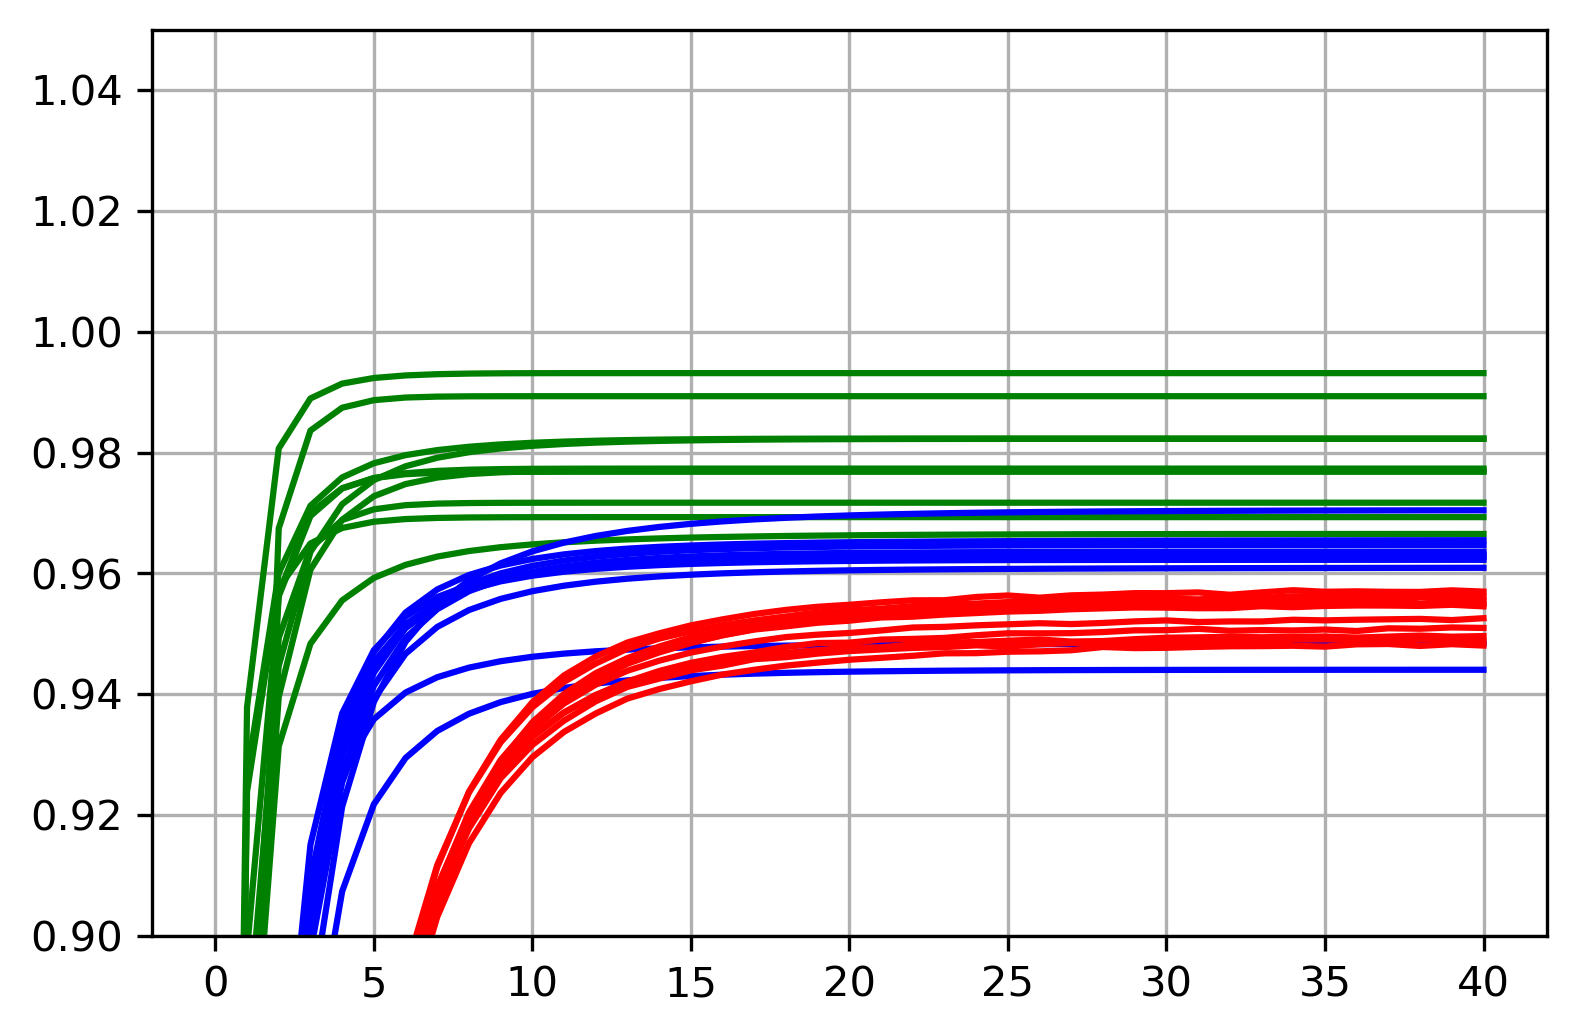

In [70]:
fig = plt.figure(figsize=(6, 4), dpi=300, facecolor="w", edgecolor="k")

plt.plot(-np.array(fidelity_oneQubits).T,"g-")
plt.plot(-np.array(fidelity_twoQubits).T,"b-")
plt.plot(-np.array(fidelity_threeQubits).T,"r-")
#plt.yscale("log")
plt.ylim([0.9, 1.05])
plt.grid()
plt.show()